# Lab Session 11

# Naive Bayes

## Gaussian Naive Bayes

**Data from each label is drawn from a simple Gaussian distribution**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

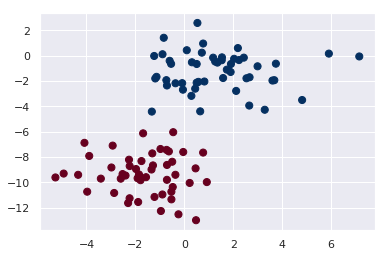

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Simple model:
- data is described by a Gaussian distribution
- no covariance between features 

*Fit sample mean and sample standard deviation of the points within each label*

[(-15, 5), (-8, 8)]

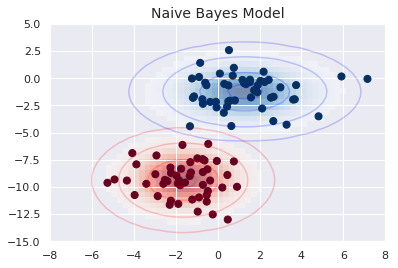

In [3]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

Ellipses here represent the Gaussian generative model ~ simple recipe to compute the likelihood 
$$\mathcal{P}(X | Y_{i})$$

In [4]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [5]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

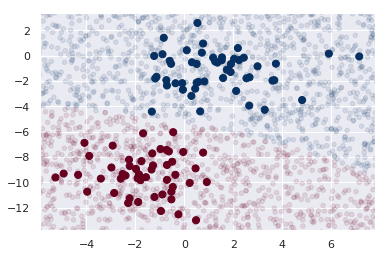

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

In [7]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

## Multinomial Naive Bayes

Except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

### Classifying Text


Use sparse word count features from the 20 Newsgroups **corpus** (a set of texts used as a base for the study of language) to show how we might classify these short documents into categories

In [8]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

select just a few of these categories

In [9]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

sample entry from the data

In [10]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Convert the content of each string into a vector of numbers. 
For this we will use the [TF-IDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), and create a pipeline that attaches it to a multinomial naive Bayes classifier (To be able to apply the model to the training data, and predict labels for the test data).

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [12]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

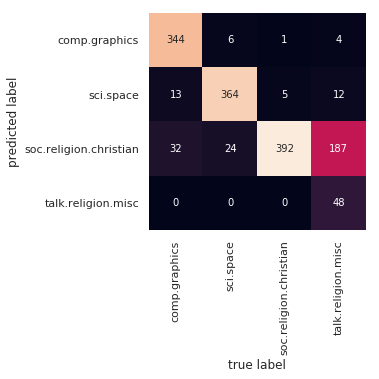

In [13]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [14]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [15]:
predict_category('sending a payload to the ISS')

'sci.space'

In [16]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [17]:
predict_category('determining the screen resolution')

'comp.graphics'

# pandas-profiling

Generates profile reports from a pandas `DataFrame`. The pandas `df.describe()` function is great but a little basic for serious exploratory data analysis.

For each column the following statistics - if relevant for the column type - are presented in an interactive HTML report:

* **Essentials**:  type, unique values, missing values
* **Quantile statistics** like minimum value, Q1, median, Q3, maximum, range, interquartile range
* **Descriptive statistics** like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
* **Most frequent values**
* **Histogram**
* **Correlations** highlighting of highly correlated variables, Spearman and Pearson matrixes

[pandas-profiling Meteorites example](http://nbviewer.jupyter.org/github/JosPolfliet/pandas-profiling/blob/master/examples/meteorites.ipynb)

# Support Vector Classifier

## Platt scaling

### Data

[Women’s Clothing E-Commerce](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/home) dataset revolving around the reviews written by customers. Its nine supportive features offer a great environment to parse out the text through its multiple dimensions. Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with “retailer”.

This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:
- Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
- Age: Positive Integer variable of the reviewers age.
- Title: String variable for the title of the review.
- Review Text: String variable for the review body.
- Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
- Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
- Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
- Division Name: Categorical name of the product high level division.
- Department Name: Categorical name of the product department name.
- Class Name: Categorical name of the product class name.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas_profiling
%matplotlib inline

In [19]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## pandas-profiling

In [41]:
### pandas-profiling
pandas_profiling.ProfileReport(df)

Number of variables,12
Number of observations,19662
Total Missing (%),0.0%
Total size in memory,1.8 MiB
Average record size in memory,96.0 B
Numeric,5
Categorical,5
Boolean,1
Date,0
Text (Unique),0
Rejected,1


In [43]:
pfr = pandas_profiling.ProfileReport(df)
pfr.to_file("example.html")

In [21]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cubazis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cubazis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

convert list of list into text

In [22]:
a = df['Review Text'].str.lower().str.cat(sep=' ')

removes punctuation,numbers and returns list of words

In [23]:
b = re.sub('[^A-Za-z]+', ' ', a)

remove all the stopwords from the text

In [24]:
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

In [25]:
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

Remove characters which have length less than 2  

In [26]:
without_single_chr = [word for word in filtered_sentence if len(word) > 2]


Remove numbers

In [27]:
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]

In [28]:
df=df.dropna(axis=0,how='any')
rating_class = df[(df['Rating'] == 1) | (df['Rating'] == 5)]
X_review=rating_class['Review Text']
y=rating_class['Rating']

In [29]:
import string
def text_process(review):
    nopunc=[word for word in review if word not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [31]:
bow_transformer = TfidfVectorizer(analyzer=text_process).fit(X_review)
X_review = bow_transformer.transform(X_review)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)
from sklearn.svm import SVC
svc = SVC(kernel='linear',probability = True)
svc.fit(X_train, y_train) 
svc.score(X_train,y_train)

0.9909698169223157

In [33]:
svc.predict_proba(X_test)

array([[6.27478787e-01, 3.72521213e-01],
       [4.98633302e-06, 9.99995014e-01],
       [1.17999297e-08, 9.99999988e-01],
       ...,
       [2.69273608e-03, 9.97307264e-01],
       [4.34936213e-06, 9.99995651e-01],
       [9.88998417e-07, 9.99999011e-01]])

In [34]:
svc.classes_

array([1, 5])

In [35]:
bow_transformer.inverse_transform(X_test)[1]

array(['Love', 'comfy', 'fit', 'great', 'jacket', 'love', 'much',
       'traveling', 'way', 'wears'], dtype='<U32')

According Linear SVC, the following review has a posterior probability of around 99.99% for being rated as 5

In [36]:
df['Review Text'][7698]

"I love these socks so much! i ordered the beige and red pair with the polar bear design and they are my new favorite socks. these are comfy, with great stretch and just the right amount of cushion. however, the best feature is the cute little frill around the cuff! i want to order more, but i don't care for the other designs as much as the pair i ordered. instead, i will be keeping an eye on this brand to see what they come out with next!"

This turned out to be right

In [37]:
transformed_rating = bow_transformer.transform([df['Review Text'][7698]])
svc.predict(transformed_rating)[0]

5

In [39]:
predict = svc.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predict))

[[  98  101]
 [   8 3258]]


In [40]:
print(classification_report(y_test, predict))

             precision    recall  f1-score   support

          1       0.92      0.49      0.64       199
          5       0.97      1.00      0.98      3266

avg / total       0.97      0.97      0.96      3465

